In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, Input, Add
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
from skimage.metrics import peak_signal_noise_ratio as psnr, structural_similarity as ssim
import os
import cv2
import time

In [ ]:
# Define the DnCNN model
def DnCNN(depth=17, filters=64, image_channels=3, use_bnorm=True):
    layer_count = 0
    inpt = Input(shape=(None, None, image_channels), name='input' + str(layer_count))
    layer_count += 1
    x = Conv2D(filters=filters, kernel_size=(3, 3), padding='same', kernel_initializer='he_normal', name='conv' + str(layer_count))(inpt)
    layer_count += 1
    x = Activation('relu', name='relu' + str(layer_count))(x)
    for i in range(depth - 2):
        layer_count += 1
        x = Conv2D(filters=filters, kernel_size=(3, 3), padding='same', kernel_initializer='he_normal', name='conv' + str(layer_count))(x)
        if use_bnorm:
            layer_count += 1
            x = BatchNormalization(axis=3, epsilon=1e-3, name='bn' + str(layer_count))(x)
        layer_count += 1
        x = Activation('relu', name='relu' + str(layer_count))(x)
    layer_count += 1
    x = Conv2D(filters=image_channels, kernel_size=(3, 3), padding='same', kernel_initializer='he_normal', name='conv' + str(layer_count))(x)
    layer_count += 1
    outpt = Add(name='add' + str(layer_count))([inpt, x])
    model = Model(inputs=inpt, outputs=outpt)
    return model

In [ ]:
# Custom data generator
def custom_data_generator(original_image_folder, pixelated_image_folder, batch_size=16, image_size=(256, 256)):
    original_images = sorted([os.path.join(original_image_folder, f) for f in os.listdir(original_image_folder) if f.endswith('.jpg') or f.endswith('.png')])
    pixelated_images = sorted([os.path.join(pixelated_image_folder, f) for f in os.listdir(pixelated_image_folder) if f.endswith('.jpg') or f.endswith('.png')])

    while True:
        batch_original = []
        batch_pixelated = []

        for _ in range(batch_size):
            idx = np.random.randint(0, len(original_images))
            original_img = cv2.imread(original_images[idx])
            pixelated_img = cv2.imread(pixelated_images[idx])

            if original_img is not None and pixelated_img is not None:
                original_img = cv2.resize(original_img, image_size)
                pixelated_img = cv2.resize(pixelated_img, image_size)

                batch_original.append(original_img)
                batch_pixelated.append(pixelated_img)

        batch_original = np.array(batch_original) / 255.0
        batch_pixelated = np.array(batch_pixelated) / 255.0

        yield batch_pixelated, batch_original

# Paths to image folders
original_image_folder = '/content/drive/MyDrive/pixelation/original_images'
pixelated_image_folder = '/content/drive/MyDrive/pixelation/pixelated_images'

In [ ]:
# Compile and train the model
model = DnCNN()
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss=tf.keras.losses.MeanSquaredError())

batch_size = 8
original_image_folder = '/content/drive/MyDrive/pixelation/original_images'
pixelated_image_folder = '/content/drive/MyDrive/pixelation/pixelated_images'
steps_per_epoch = len(os.listdir(pixelated_image_folder)) // batch_size

model.fit(custom_data_generator(original_image_folder, pixelated_image_folder, batch_size=batch_size),
          steps_per_epoch=steps_per_epoch,
          epochs=50)
# Save the model
model_path = '/content/drive/MyDrive/pixelation/pixelation_correction_model.h5'
model.save(model_path)

Epoch 1/50
107/107 [==============================] - 134s 1s/step - loss: 0.1566
Epoch 2/50
107/107 [==============================] - 78s 725ms/step - loss: 0.1270
Epoch 3/50
107/107 [==============================] - 75s 700ms/step - loss: 0.1253
Epoch 4/50
107/107 [==============================] - 76s 709ms/step - loss: 0.1234
Epoch 5/50
107/107 [==============================] - 77s 725ms/step - loss: 0.1223
Epoch 6/50
107/107 [==============================] - 77s 707ms/step - loss: 0.1187
Epoch 7/50
107/107 [==============================] - 81s 763ms/step - loss: 0.1176
Epoch 8/50
107/107 [==============================] - 75s 705ms/step - loss: 0.1166
Epoch 9/50
107/107 [==============================] - 75s 701ms/step - loss: 0.1164
Epoch 10/50
107/107 [==============================] - 78s 726ms/step - loss: 0.1152
Epoch 11/50
107/107 [==============================] - 76s 716ms/step - loss: 0.1149
Epoch 12/50
107/107 [==============================] - 74s 694ms/step - loss

1/1 [==============================] - 4s 4s/step


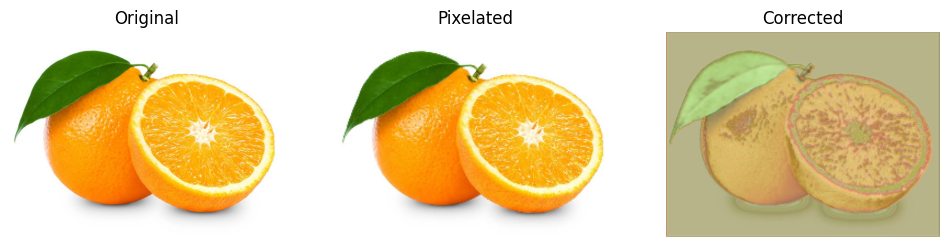

<ipython-input-12-31ff6624dac7>:38: UserWarning: Inputs have mismatched dtype.  Setting data_range based on image_true.
  psnr_value = psnr(original_img, corrected_img)
<ipython-input-12-31ff6624dac7>:39: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(original_img, corrected_img, multichannel=True)
/usr/local/lib/python3.10/dist-packages/skimage/_shared/utils.py:348: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  return func(*args, **kwargs)


PSNR: 1.59
SSIM: 0.0464


In [ ]:
# Load and evaluate the model
model = tf.keras.models.load_model(model_path)

# Load an example image
original_img_path = '/content/drive/MyDrive/pixelation/original_images/orange_1.jpg'
pixelated_img_path = '/content/drive/MyDrive/pixelation/pixelated_images/orange_1.jpg_scale_6.jpg'

original_img = cv2.imread(original_img_path)
pixelated_img = cv2.imread(pixelated_img_path)

# Predict the corrected image
corrected_img = model.predict(np.expand_dims(pixelated_img / 255.0, axis=0))[0]

# Plot the results
def plot_sample_images(original_img, pixelated_img, corrected_img):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    plt.title("Original")
    plt.imshow(cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB))
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.title("Pixelated")
    plt.imshow(cv2.cvtColor(pixelated_img, cv2.COLOR_BGR2RGB))
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.title("Corrected")
    plt.imshow(cv2.cvtColor(corrected_img, cv2.COLOR_BGR2RGB))
    plt.axis('off')

    plt.show()

plot_sample_images(original_img, pixelated_img, corrected_img)

# Calculate PSNR and SSIM
psnr_value = psnr(original_img, corrected_img)
ssim_value = ssim(original_img, corrected_img, multichannel=True)

print(f"PSNR: {psnr_value:.2f}")
print(f"SSIM: {ssim_value:.4f}")

In [ ]:
# Check the model size
model_size = os.path.getsize(model_path) / (1024 * 1024)  # Convert bytes to MB
print(f"Model size: {model_size:.2f} MB")

Model size: 6.69 MB


In [ ]:

# Function to measure FPS
def measure_fps(model, image, num_frames=100):
    start_time = time.time()

    for _ in range(num_frames):
        _ = model.predict(np.expand_dims(image / 255.0, axis=0))

    end_time = time.time()
    total_time = end_time - start_time
    fps = num_frames / total_time

    return fps

# Load a sample pixelated image
pixelated_img_path = '/content/drive/MyDrive/pixelation/pixelated_images/orange_1.jpg_scale_6.jpg'
pixelated_img = cv2.imread(pixelated_img_path)
pixelated_img = cv2.resize(pixelated_img, (256, 256))  # Resize for consistency

# Measure FPS
fps = measure_fps(model, pixelated_img)
print(f"FPS: {fps:.2f}")

# Ensure the model meets the requirements
if model_size < 10 and fps >= 30:
    print("The model meets the size and performance requirements.")
else:
    print("The model does not meet the size and performance requirements.")

1/1 [==============================] - 0s 26ms/step
FPS: 9.00
The model does not meet the size and performance requirements.
